# Quasi-Newton methods: BFGS
without computation of the hessian=> we exploit only the gradient

In [4]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.optimize
import scipy as sp
import matplotlib.pyplot as plt

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

Consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), that is minimized in $\mathbf{x} = (1,1,\dots,1)^T$:

$$\mathcal{L}(\mathbf{x}) = \sum_{i=1}^{N-1} [100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2]$$

In [5]:
def loss(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

Use `jax` to compute and compile the Rosenbrock function and its gradient.

In [6]:
loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=0))

Implement the BFGS method (with line search) for the minimization of the Rosenbrock function.
Set a maximum of 1000 epochs and a stopping tolerance on the gradient eucledian norm of $10^{-8}$. Employ an initial guess for $\mathbf{x}$ with random numbers in the interval $[0,2]$.

522 epochs
error 9.910e-11


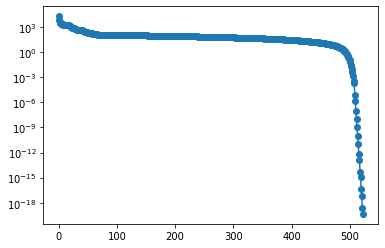

In [9]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x = np.random.rand(N)*2

grad = grad_jit(x)
I = np.identity(N)
Binv = I.copy()

hist = [loss_jit(x)]
epoch=0

while (epoch < 1000 and np.linalg.norm(grad)>tol):
    epoch += 1
    # search direction = -Hessian @ grad
    p = -Binv @ grad
    
    # line search: search along the straight line
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p

    #update of Binv
    grad_new = grad_jit(x_new)
    y = grad_new - grad 
    s = x_new - x
    x = x_new
    grad = grad_new
    rho = 1.0/np.inner(y,s)
    E = I - rho * np.outer(y,s)
    Binv = E.T @ Binv @ E +rho * np.outer(s,s)

    hist.append(loss_jit(x))

print("%d epochs" % epoch)
x_ex = np.ones(N)
err = x -x_ex
print("error %1.3e" % np.linalg.norm(err))
plt.semilogy(hist, 'o-')


    